# VLLE calculation for ternary mixtures with SAFT-$\gamma$-Mie

In this notebook, the VLLE calculations with ```saftgammamie``` EoS are illustrated.

First, all the needed modules are imported.

- NumPy: numerical interface and work with arrays
- matplotlib: to plot results
- ternary: plot ternary plots in python.
- SGTPy: package with SAFT-$\gamma$-Mie EoS and phase equilibria functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ternary
from mpl_toolkits.mplot3d import Axes3D
from SGTPy import component, mixture, saftgammamie
from SGTPy.equilibrium import vlle

Now, pure components are configured and created with the ```component``` function. Then, a mixture is created with them using the ```mixture``` function or by adding (`+`) pure components. The interaction parameters are set up with the ```mixture.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.

For this notebook all calculations are exemplified for a mixture of butanol, water and hexane.

In [2]:
hexane = component(GC={'CH3':2, 'CH2':4})
butanol = component(GC={'CH3':1, 'CH2':2, 'CH2OH':1})
water = component(GC={'H2O':1})

# creating mixture with the mixture function
mix = mixture(butanol, water)
mix.add_component(hexane)
# or creating mixture by adding pure components
mix = butanol + water + hexane

mix.saftgammamie()
eos = saftgammamie(mix)

## VLLE calculation

This type of equilibria calculation is carried out at given global composition (z), temperature (K), and pressure (Pa). This calculation can be perfomed with the ```vlle```function. This function requires initial guesses for the phase composition of the two liquids: ```x0```, ```w0```  and the vapor ```y0```.

Initial guesses can be obtained from a previous calculation or by a tpd minimization.

The ```full_output``` option allows obtaining all the information related to the multiflash calculation. This includes the volume of the phases and the solution for the fraction of the nonbonded sites of each phase.

In [3]:
# multiflash conditions
T = 357.  # K
P = 1.01325e5  # Pa
Z = np.array([0.25, 0.7, 0.05])

# initial guesses
x0 = np.array([0.4, 0.6, 0.0])
w0 = np.array([0.05, 0.9, 0.05])
y0 = np.array([0.4, 0.5, 0.1])

vlle(x0, w0, y0, Z, T, P, eos, full_output=True)

           T: 357.0
           P: 101325.0
 error_outer: 4.134229609357571e-06
 error_inner: 5.581655843604942e-09
        iter: 34
        beta: array([0.55720937, 0.30720603, 0.13558459])
       tetha: array([0., 0., 0.])
           X: array([[3.99931324e-01, 5.94802353e-01, 5.26632309e-03],
       [3.48461429e-02, 9.65148437e-01, 5.42026824e-06],
       [1.21323312e-01, 5.31558415e-01, 3.47118273e-01]])
           v: [4.922411526135986e-05, 2.115773869219071e-05, 0.02845068469646685]
        Xass: [array([0.36680798, 0.20003905, 0.09512894, 0.42013232]), array([0.61304708, 0.06785098, 0.11488599, 0.14155535]), array([0.99637455, 0.96982848, 0.98130912, 0.98778176])]
      states: ['L', 'L', 'V']

In the previous calculation, both volume and nonbonded association sites were automatically initialized. When a good initial guess for any of these is available, they can be supplied to the ```vlle``` function.

This will result in a **faster** calculation.

- Initial guesses for volumes are passed to the function to the ```v0``` option. 
- Initial guesses for nonbonded sites fraction are passed to the function to the ```Xass0```option.

In [4]:
# multiflash conditions
T = 357.  # K
P = 1.01325e5  # Pa
Z = np.array([0.25, 0.7, 0.05])

# initial guesses
x0 = np.array([0.4, 0.6, 0.0])
w0 = np.array([0.05, 0.9, 0.05])
y0 = np.array([0.4, 0.5, 0.1])

# initial guesses for phase volumes and non bonded sites fractions
v0 = [4.922411526135986e-05, 2.115773869219071e-05, 0.02845068469646685]
Xass0 = [np.array([0.36680798, 0.20003905, 0.09512894, 0.42013232]), 
         np.array([0.61304708, 0.06785098, 0.11488599, 0.14155535]),
         np.array([0.99637455, 0.96982848, 0.98130912, 0.98778176])]

vlle(x0, w0, y0, Z, T, P, eos, v0=v0, Xass0=Xass0, full_output=True)

           T: 357.0
           P: 101325.0
 error_outer: 4.133353864743988e-06
 error_inner: 5.581655624905702e-09
        iter: 34
        beta: array([0.55720937, 0.30720603, 0.13558459])
       tetha: array([0., 0., 0.])
           X: array([[3.99931324e-01, 5.94802353e-01, 5.26632309e-03],
       [3.48461429e-02, 9.65148437e-01, 5.42026824e-06],
       [1.21323312e-01, 5.31558415e-01, 3.47118273e-01]])
           v: [4.9224115261353144e-05, 2.1157738692192085e-05, 0.028450684696466867]
        Xass: [array([0.36680798, 0.20003905, 0.09512894, 0.42013232]), array([0.61304708, 0.06785098, 0.11488599, 0.14155535]), array([0.99637455, 0.96982848, 0.98130912, 0.98778176])]
      states: ['L', 'L', 'V']

## Whole three-phase diagram computation

In the following codeblock, the whole three-phase diagram is computed at constant pressure.
It is advised to store the computed volume roots and nonbonded sites fraction, as these can be used in the following iterations to speed up calculations.

To compute a ternary VLLE diagram it is recommended to compute VLLE for the binary subsystems first (butanol+water and water+hexane). 

The ```vlle``` function can solve three-phase equilibria for binary subsystems but it will update the temperature to the one computed.

In [5]:
n = 100
X = np.zeros([n,3])
W = np.zeros([n,3])
Y = np.zeros([n,3])
vs = np.zeros([n, 3])
P = 1.01325e5  # Pa


# VLLE Butanol - Water
i = 0
z = np.array([0.3, 0.7, 0.])

x0 = np.array([0.4, 0.6, 0.])
w0 = np.array([0.05, 0.95, 0.])
y0 = np.array([0.2, 0.8, 0.])
T0 = 368. 

sol = vlle(x0, w0, y0, z, T0, P, eos, full_output=True)
T11 = sol.T
X[i], W[i], Y[i] = sol.X
vs[i] = sol.v
xass11 = sol.Xass


# VLLE Water - Hexane
i = -1
z = np.array([0.0, 0.5, 0.5])
x0 = np.array([0., 0.01, 0.99])
w0 = np.array([0., 0.99, 0.01])
y0 = np.array([0., 0.4, 0.6])
T0 = 330. 

sol = vlle(x0, w0, y0, z, T0, P, eos, full_output=True)
T1 = sol.T
X[i], W[i], Y[i] = sol.X
vs[i] = sol.v
xass = sol.Xass

C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\equilibrium\hazt.py:263: UserWarning: Global mixture is a binary mixture, updating temperature
  warn('Global mixture is a binary mixture, updating temperature')


Now that we have the temperature interval where the mixture exhibits three-phase equilibria, we can compute the VLLE for the ternary zone.

It is recommended to check that the first point of VLLE in the ternary zone converges correctly (problems might arise due to global composition or bad initial guesses).

In [6]:
# temperature interval for VLLE
T = np.linspace(T11, T1, n)

# calculation of first point
i = 1
Z = (X[i-1] + W[i-1] + Y[i-1]) / 3
Z[2] += 0.007
Z /= np.sum(Z)

sol = vlle(X[i-1], W[i-1], Y[i-1], Z, T[i], P, eos, v0=vs[i-1], full_output=True)
X[i], W[i], Y[i] = sol.X
vs[i] = sol.v
xass = sol.Xass
sol

           T: 367.84939756679074
           P: 101325.0
 error_outer: 3.31012793592664e-11
 error_inner: 1.9296137106632838e-10
        iter: 16
        beta: array([0.22616758, 0.21390757, 0.55992484])
       tetha: array([0., 0., 0.])
           X: array([[3.65816342e-01, 6.34072211e-01, 1.11446158e-04],
       [3.75384269e-02, 9.62461374e-01, 1.99277640e-07],
       [1.89049029e-01, 7.98581289e-01, 1.23696824e-02]])
           v: array([4.65703219e-05, 2.15455741e-05, 2.89524116e-02])
        Xass: [array([0.40684506, 0.19684832, 0.10890409, 0.4011628 ]), array([0.6141833 , 0.07547398, 0.12563731, 0.15417225]), array([0.9953391 , 0.96349467, 0.97680774, 0.984898  ])]
      states: ['L', 'L', 'V']

Now the rest of the diagram is computed using the global composition of the previous point, and the computed equilibria compositions as initial guesses.

The volumes and non-bonded sites fractions are stored and used in the following iteration.

In [7]:
for i in range(2, n-1):
    Z = (X[i-1] + W[i-1] + Y[i-1])/3
    sol = vlle(X[i-1], W[i-1], Y[i-1], Z, T[i], P, eos, v0=vs[i-1], Xass0=xass, full_output=True)
    X[i], W[i], Y[i] = sol.X
    vs[i] = sol.v
    xass = sol.Xass
    print(i, T[i], sol.tetha, sol.beta, sol.error_inner, sol.error_outer, sol.iter)

2 367.50468289836516 [0. 0. 0.] [0.41104592 0.42380352 0.16515057] 1.858050514975831e-10 3.312329804507744e-11 16
3 367.1599682299395 [0. 0. 0.] [0.38445166 0.39386778 0.22168057] 1.8647307781288064e-10 3.304209384651562e-11 16
4 366.81525356151394 [0. 0. 0.] [0.37115402 0.37889826 0.24994772] 1.8663540590075532e-10 3.300115342243985e-11 16
5 366.4705388930883 [0. 0. 0.] [0.36317501 0.36991534 0.26690965] 1.865966401769416e-10 3.2995823748544457e-11 16
6 366.1258242246627 [0. 0. 0.] [0.35785529 0.36392579 0.27821892] 1.8645733982962585e-10 3.302942995198616e-11 16
7 365.7811095562371 [0. 0. 0.] [0.35405515 0.35964683 0.28629802] 1.8626018506984044e-10 3.3107196902193505e-11 16
8 365.4363948878115 [0. 0. 0.] [0.35120472 0.35643704 0.29235823] 1.8602594867046707e-10 3.322358636013005e-11 16
9 365.09168021938586 [0. 0. 0.] [0.34898743 0.35394011 0.29707247] 1.8576628413060553e-10 3.338364225289516e-11 16
10 364.7469655509602 [0. 0. 0.] [0.34721331 0.35194221 0.30084448] 1.8548804528390508

74 342.68522677172103 [0. 0. 0.] [0.33306959 0.33696008 0.32997034] 1.7261018408876327e-10 7.892820997074503e-11 22
75 342.3405121032954 [0. 0. 0.] [0.33302384 0.3369658  0.33001036] 1.7249783196282634e-10 6.271908846953701e-11 23
76 341.9957974348698 [0. 0. 0.] [0.3329787  0.33697424 0.33004707] 1.72227305893792e-10 8.124629203040024e-11 23
77 341.6510827664442 [0. 0. 0.] [0.33293248 0.33698752 0.33008   ] 1.7210321933587936e-10 6.783509436473862e-11 24
78 341.3063680980186 [0. 0. 0.] [0.33288664 0.3370041  0.33010926] 1.7182591220743674e-10 9.001514549439254e-11 24
79 340.96165342959296 [0. 0. 0.] [0.33283945 0.33702629 0.33013426] 1.7170460378983022e-10 7.634173853209675e-11 25
80 340.6169387611674 [0. 0. 0.] [0.3327924 0.3370526 0.330155 ] 1.7143541855293065e-10 9.920369836423798e-11 25
81 340.27222409274174 [0. 0. 0.] [0.33274402 0.33708517 0.33017081] 1.7121135805352964e-10 1.0617544038996607e-05 25
82 339.9275094243161 [0. 0. 0.] [0.3326945  0.33712427 0.33018124] 1.710964187147

The results are plotted bellow.

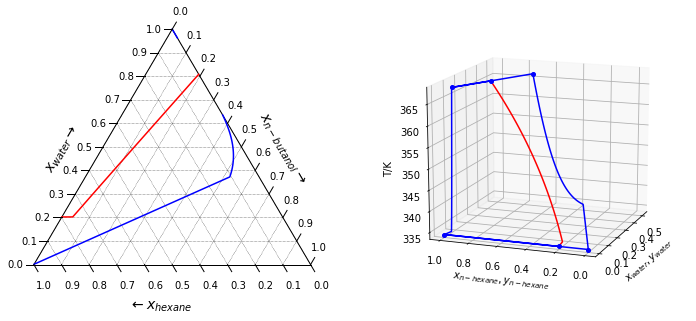

In [8]:
fig = plt.figure(figsize = (12,5))

fontsize = 14
ax3 = fig.add_subplot(121)
tax = ternary.TernaryAxesSubplot(ax=ax3, scale = 1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(color="black", multiple=0.1, linewidth=0.5)

tax.plot(X, color = "b")
tax.plot(W, color = "b")
tax.plot(Y, color = "r")

#tax.legend()
# Set ticks
tax.ticks(clockwise=True, multiple=0.1, linewidth=1, offset = 0.03,tick_formats='%.1f')

#Set labels
tax.right_axis_label(r"$x_{n-butanol}\rightarrow$", fontsize=fontsize, offset = 0.15)
tax.left_axis_label(r"$x_{water} \rightarrow$", fontsize=fontsize, offset = 0.15)
tax.bottom_axis_label(r"$\leftarrow x_{hexane}$", fontsize=fontsize, offset = 0.15)

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax._redraw_labels()
ternary.plt.axis('off')


ax = fig.add_subplot(122, projection='3d')

# ternary three phase equilibria
ax.plot(X.T[0], X.T[1], T, 'b')
ax.plot(W.T[0], W.T[1], T, 'b')
ax.plot(Y.T[0], Y.T[1], T, 'r')

# binary vlle
ax.plot([X[0,0], W[0,0], Y[0,0]], [X[0,1], W[0,1], Y[0,1]], [T[0], T[0], T[0]], 'o-',markersize = 4, color='b')
ax.plot([X[-1,0], W[-1,0], Y[-1,0]], [X[-1,1], W[-1,1], Y[-1,1]], [T[-1], T[-1], T[-1]],
        'o-', color = 'b', markersize = 4)

ax.set_xlabel(r"$x_{water}, y_{water}$")
ax.set_ylabel(r"$x_{n-hexane}, y_{n-hexane}$")
ax.set_zlabel("T/K", rotation = 90)
#ax.view_init(elev=16, azim=-110)
ax.view_init(elev=15, azim=-160)

For further information of any of these functions just run: ```function?```